In [1]:
import numpy as np
import patato as pat
import matplotlib.pyplot as plt

from utils import remove_tick_labels, add_scalebar, setup_matplotlib
from tqdm.auto import tqdm
import pandas as pd
import matplotlib.transforms as transforms

from pathlib import Path

setup_matplotlib(300)

In [2]:
data_directory = Path("/media/telse/Extreme SSD/Papers/IPASCMultiCentre/Fixed/Data3")

In [3]:
masks = np.load("translated_masks.npz")

In [4]:
def sort_key(s):
    return int(s.stem.split("_")[-1])

In [ ]:
data_files = sorted(data_directory.glob("**/Scan_*.hdf5"), key=sort_key)
spectra = []

for file in tqdm(data_files):
    pa = pat.PAData.from_hdf5(file)
    # print(pa.get_scan_reconstructions().keys())
    if "Clear" in pa.get_scan_name() or ('Reference Backprojection', '0') not in pa.get_scan_reconstructions(): # pyright: ignore[reportOperatorIssue]
        print(file, pa.get_scan_name())
        continue
    pa.set_default_recon(('Reference Backprojection', '0')) # pyright: ignore[reportArgumentType]
    rec1 = pa.get_scan_reconstructions()
    
    rec_data = np.squeeze(rec1.raw_data) # type: ignore
    # rec_data /= pa.get_overall_correction_factor()[:, :, None, None]
    mask = masks[str(file)]
    for i in range(mask.shape[0]):
        m = mask[i] & np.all(rec_data[i] > 0, axis=0)
        spectrum = rec_data[i].T[m.T].T
        spectra.append({"PA": np.median(spectrum, axis=1), "Wavelength": pa.get_wavelengths(), "Scan": pa.get_scan_name(), "File": file})


  0%|          | 0/41 [00:00<?, ?it/s]

In [53]:
df = pd.DataFrame(spectra)

In [54]:
df["Operator"] = df["Scan"].apply(lambda x:" ".join(x.split("_")[:-1]))
df["Operator"] = df["Operator"].apply(lambda x:x.replace(" Nigrosin", ""))
df["Replicate"] = df["Scan"].apply(lambda x:x.split("_")[-1])

# display(df[df["Operator"] == "LW05"].iloc[0]["File"])

del df["Scan"]
del df["File"]

In [55]:
df_g = df.groupby(["Operator", "Replicate"]).mean().reset_index()
df_g.tail()

,Operator,Replicate,PA,Wavelength
36,LW16,2,"[181.05914306640625, 182.10824584960938, 178.8...","[660.0, 670.0, 680.0, 690.0, 700.0, 710.0, 720..."
37,LW20,1,"[310.4100036621094, 319.71112060546875, 317.17...","[660.0, 670.0, 680.0, 690.0, 700.0, 710.0, 720..."
38,LW20,2,"[344.7871398925781, 355.9551086425781, 349.791...","[660.0, 670.0, 680.0, 690.0, 700.0, 710.0, 720..."
39,LW20,3,"[323.9409484863281, 331.9571533203125, 327.651...","[660.0, 670.0, 680.0, 690.0, 700.0, 710.0, 720..."
40,LW21,1,"[70.9470926920573, 69.06381734212239, 68.98691...","[660.0, 670.0, 680.0, 690.0, 700.0, 710.0, 720..."


In [56]:
df_g["Operator"] = df_g["Operator"].apply(lambda x: x.split()[0])
df_long = df_g.explode(["PA", "Wavelength"])
df_long.to_excel("20250519_ipasc_multicentre_ipasc.xlsx")

## Separate out the LPM/HPM

In [57]:
df_details = pd.read_excel("scandetails.ods")[["Reference", "Recipe"]]

In [58]:
df_recipe = df_g.merge(df_details, left_on="Operator", right_on="Reference")

In [59]:
df_summarised = df_recipe.groupby("Operator").agg({"Recipe": "first", 
                                                   "PA": lambda x: {"Mean": np.mean(np.stack(x), axis=0), 
                                                                    "Std": np.std(np.stack(x), axis=0)}, 
                                                   "Wavelength": "first"})
df_summarised = df_summarised.drop(index="LW21")
df_summarised = df_summarised.drop(index="LW04")
df_summarised = pd.concat([df_summarised, df_summarised["PA"].apply(pd.Series)], axis=1)
del df_summarised["PA"]
df_summarised["PA"] = df_summarised["Mean"]
df_summarised["PA Std"] = df_summarised["Std"]
del df_summarised["Mean"]
del df_summarised["Std"]
df_summarised["CoV"] = df_summarised["PA Std"] / df_summarised["PA"]
df_summarised.head()

,Recipe,Wavelength,PA,PA Std,CoV
Operator,,,,,
LW03,HPM,"[660.0, 670.0, 680.0, 690.0, 700.0, 710.0, 720...","[292.7443440755208, 303.58607991536456, 300.54...","[6.446724808711214, 6.7506016366986366, 6.8555...","[0.02202168868221795, 0.02223620278828531, 0.0..."
LW05,HPM,"[660.0, 670.0, 680.0, 690.0, 700.0, 710.0, 720...","[252.94283718532984, 255.9777645534939, 244.96...","[22.92566535562833, 24.074778899636286, 24.880...","[0.09063575632636246, 0.09405027402137958, 0.1..."
LW06,HPM,"[660.0, 670.0, 680.0, 690.0, 700.0, 710.0, 720...","[256.7577412923177, 266.41802978515625, 264.13...","[11.78207397460936, 14.52984619140625, 12.9511...","[0.045887901627844264, 0.05453777360009512, 0...."
LW07,HPM,"[660.0, 670.0, 680.0, 690.0, 700.0, 710.0, 720...","[296.7444356282552, 308.4574279785156, 303.574...","[14.59245479837743, 14.687011656341546, 14.547...","[0.04917515897975604, 0.04761438799705129, 0.0..."
LW08,HPM,"[660.0, 670.0, 680.0, 690.0, 700.0, 710.0, 720...","[267.7891387939453, 274.0193583170573, 270.155...","[10.927039836461296, 11.91047541780742, 11.281...","[0.040804641613449766, 0.04346581749171993, 0...."


Text(0.5, 0, 'Wavelength (nm)')

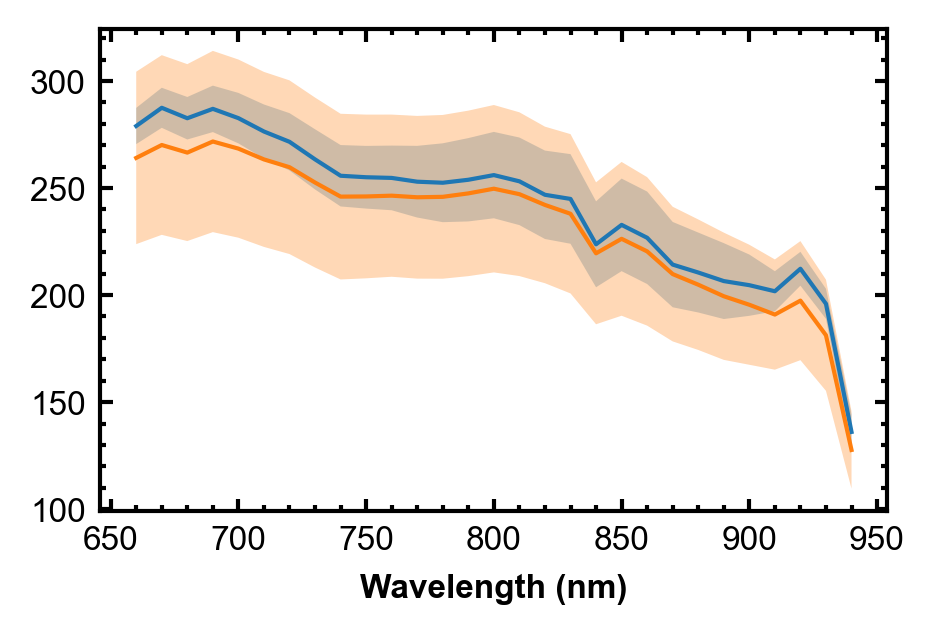

In [60]:
fig, ax = plt.subplots(figsize=(3, 2))

for recipe, rec_grp in df_summarised.groupby("Recipe"):
    wls = rec_grp["Wavelength"].iloc[0]
    spectra = np.stack(rec_grp["PA"])
    mean_spec = np.mean(spectra, axis=0)
    se_spec = np.std(spectra, axis=0) / np.sqrt(spectra.shape[0])
    
    ax.plot(wls, mean_spec, label=recipe)
    ax.fill_between(wls, mean_spec-se_spec, mean_spec + se_spec, alpha=0.3)
ax.set_xlabel("Wavelength (nm)")

## Plot the individual spectra

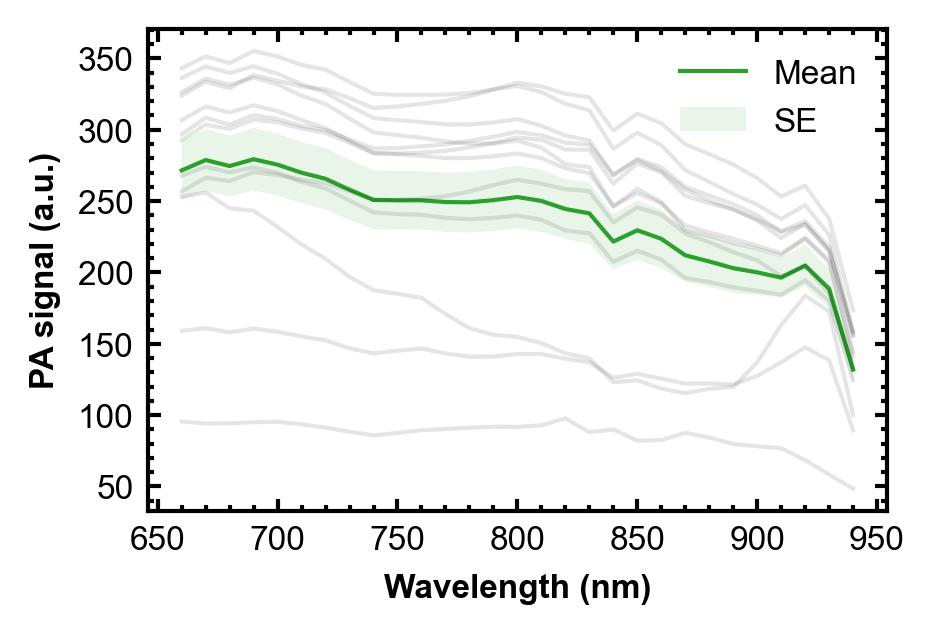

In [ ]:
fig, ax = plt.subplots(figsize=(3, 2))

wls = df_summarised["Wavelength"].iloc[0]
spectra = np.stack(df_summarised["PA"]) # type: ignore
mean_spec = np.mean(spectra, axis=0)
se_spec = np.std(spectra, axis=0) / np.sqrt(spectra.shape[0])

plt.plot(wls, mean_spec, label="Mean", c="C2")
plt.fill_between(wls, mean_spec - se_spec, mean_spec + se_spec, alpha=0.1, label="SE", facecolor="C2")

for operator, rec_grp in df_summarised.iterrows():
    wls = rec_grp["Wavelength"]
    ax.plot(wls, rec_grp["PA"], alpha=0.1, c="k")
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("PA signal (a.u.)")
ax.legend()
# ax.set_ylim([0, None])
fig.savefig("AllSpectra_Batch3.png", dpi=300)
plt.show()

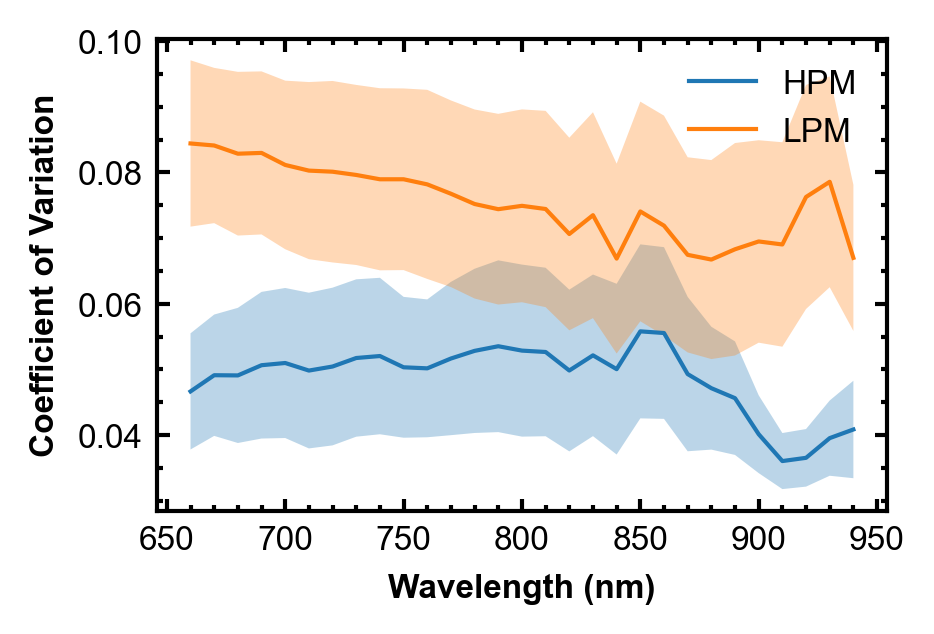

In [ ]:
fig, ax = plt.subplots(figsize=(3, 2))

for recipe, rec_grp in df_summarised.groupby("Recipe"):
    wls = rec_grp["Wavelength"].iloc[0]
    spectra = np.stack(rec_grp["CoV"]) # type: ignore
    mean_spec = np.mean(spectra, axis=0)
    se_spec = np.std(spectra, axis=0) / np.sqrt(spectra.shape[0])
    
    ax.plot(wls, mean_spec, label=recipe)
    ax.fill_between(wls, mean_spec-se_spec, mean_spec + se_spec, alpha=0.3)
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Coefficient of Variation")
ax.legend()
# ax.set_ylim([0, None])
fig.savefig("covLPMvsHPM_Batch3.png", dpi=300)
plt.show()

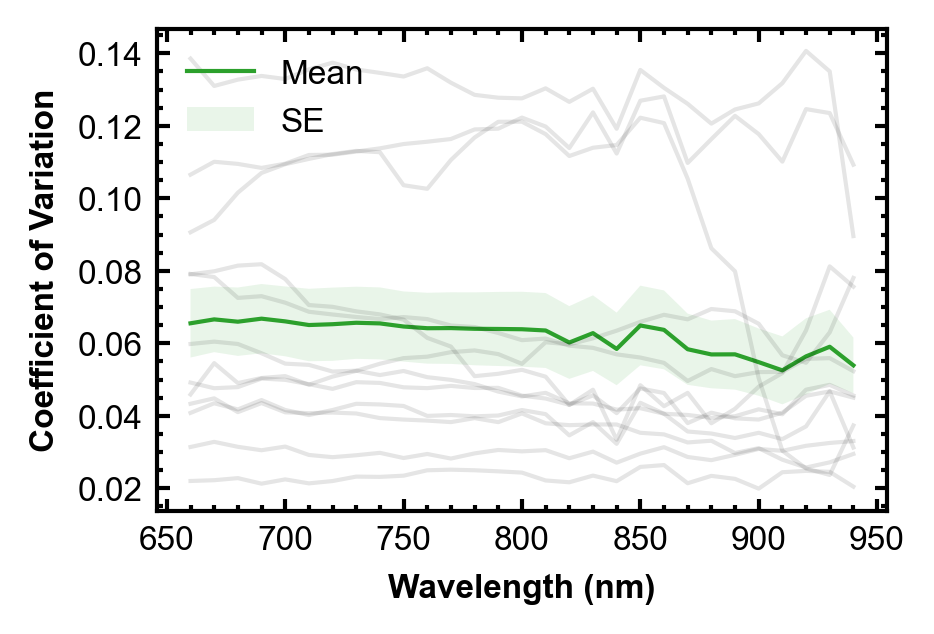

In [ ]:
fig, ax = plt.subplots(figsize=(3, 2))

wls = df_summarised["Wavelength"].iloc[0]
spectra = np.stack(df_summarised["CoV"]) # type: ignore
mean_spec = np.mean(spectra, axis=0)
se_spec = np.std(spectra, axis=0) / np.sqrt(spectra.shape[0])

plt.plot(wls, mean_spec, label="Mean", c="C2")
plt.fill_between(wls, mean_spec - se_spec, mean_spec + se_spec, alpha=0.1, label="SE", facecolor="C2")

for operator, rec_grp in df_summarised.iterrows():
    wls = rec_grp["Wavelength"]
    ax.plot(wls, rec_grp["CoV"], alpha=0.1, c="k")
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Coefficient of Variation")
ax.legend()
# ax.set_ylim([0, None])
fig.savefig("AllCoVSpectra_Batch3.png", dpi=300)
plt.show()

In [64]:
df_summarised["CoV"].apply(lambda x: x[0]).argsort()

Operator
LW03     0
LW05     5
LW06     4
LW07    11
LW08     2
LW09     3
LW10     9
LW12     7
LW14     6
LW15     1
LW16     8
LW20    10
Name: CoV, dtype: int64

In [65]:
df_summarised.iloc[1]

Recipe                                                      HPM
Wavelength    [660.0, 670.0, 680.0, 690.0, 700.0, 710.0, 720...
PA            [252.94283718532984, 255.9777645534939, 244.96...
PA Std        [22.92566535562833, 24.074778899636286, 24.880...
CoV           [0.09063575632636246, 0.09405027402137958, 0.1...
Name: LW05, dtype: object

In [67]:
example_file = Path("/media/telse/Extreme SSD/Papers/IPASCMultiCentre/Fixed/Data3/Scan_4.hdf5")

In [ ]:
pa = pat.PAData.from_hdf5(example_file) # type: ignore

HPM 6 4.872841837721966 0.21117475384568915
LPM 6 7.540791074996554 0.22258845457216894
660.0


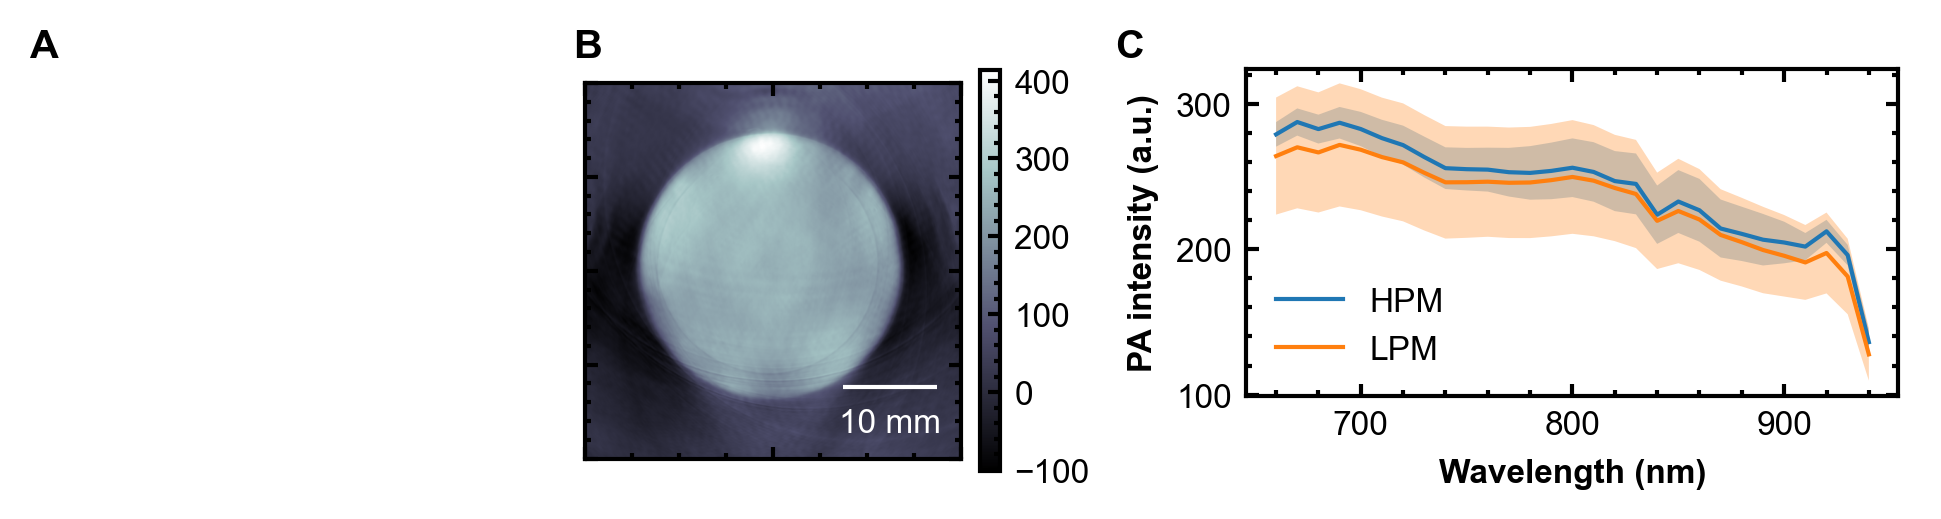

In [ ]:
fig = plt.figure(figsize=(6.27, 1.5*10.5/10))

subfigs = fig.subfigures(2, 3, width_ratios=[1, 1, 1.5], height_ratios=[0.5,10])
ax3, ax2, ax1 = [s.subplots() for s in subfigs[1]]

ax3.axis("off")

for recipe, rec_grp in df_summarised.groupby("Recipe"):
    print(recipe, rec_grp.shape[0], 100*rec_grp["CoV"].apply("mean").mean(), 100*rec_grp["CoV"].apply("mean").std()/np.sqrt(6)) # type: ignore
    wls = rec_grp["Wavelength"].iloc[0]
    spectra = np.stack(rec_grp["PA"]) # type: ignore
    mean_spec = np.mean(spectra, axis=0)
    se_spec = np.std(spectra, axis=0) / np.sqrt(spectra.shape[0])
    
    ax1.plot(wls, mean_spec, label=recipe)
    ax1.fill_between(wls, mean_spec-se_spec, mean_spec + se_spec, alpha=0.3)
ax1.set_xlabel("Wavelength (nm)")
ax1.legend()

pa.set_default_recon()
rec = pa.get_scan_reconstructions()
print(pa.get_wavelengths()[0])
im = rec.imshow(ax=ax2, scalebar=False) # type: ignore
ax2.axis("on")
add_scalebar(0.01, ax=ax2)
remove_tick_labels(np.array([ax2]))

trans = transforms.blended_transform_factory(subfigs[0, 0].transSubfigure, fig.transFigure)
fig.text(0, 1, "A", transform=trans, fontweight="bold", ha="left", va="top", fontsize="large")

trans = transforms.blended_transform_factory(subfigs[0, 1].transSubfigure, fig.transFigure)
fig.text(0, 1, "B", transform=trans, fontweight="bold", ha="left", va="top", fontsize="large")

trans = transforms.blended_transform_factory(subfigs[0, 2].transSubfigure, fig.transFigure)
fig.text(0, 1, "C", transform=trans, fontweight="bold", ha="left", va="top", fontsize="large")

ax1.set_ylabel("PA intensity (a.u.)")
plt.colorbar(im, ax=ax2) # type: ignore
plt.savefig("example_image.png", dpi=300)
plt.savefig("example_image.svg", dpi=300)
plt.show()